# Step 1: Import CPTAC Data and Define Correlation Functions

In [1]:
import cptac
import cptac.utils as ut
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import statistics as st
import load_data
import get_correlations

In [2]:
#Make docstrings for what is required
def get_single_gene_correlations(gene, cancer_type_list,type_dict,input_tissue_type = "tumor"):
    correlation_list = []
    type_list = []
    cancer_index = 0
    for cancer in cancer_type_list:
        correlation = get_correlations.correlation_list(cancer, [gene],tissue_type = input_tissue_type)[0]
        if len(correlation) == 0:
            continue
        else:
            correlation_list.append(correlation[0])
            type_list.append(type_dict[cancer])
        cancer_index += 1
    return correlation_list, type_list

In [3]:
def make_df_with_genes(gene_list,cancer_list,name_dict,tissue_type):
    all_genes = []
    all_correlations = []
    all_cancer_types = []
    for gene in gene_list:
        gene_corr_list,type_list = get_single_gene_correlations(gene,cancer_list,name_dict,tissue_type)
        gene_x,gene_y = get_x_y(gene_corr_list)
        all_genes.extend(gene_x)
        all_correlations.extend(gene_y)
        all_cancer_types.extend(type_list)
    df = pd.DataFrame(list(zip(all_genes,all_correlations,all_cancer_types)), columns =['Gene', 'Correlation','Cancer Type'])
    return(df)

In [4]:
def get_x_y(correlation_list):
    x = []
    y = []
    for item in correlation_list:
        x.append(item[0])
        y.append(item[1])
    return x,y

# Step 2: Define Desired Cancer Types

In [5]:
brca = cptac.Brca()
ccrcc = cptac.Ccrcc()
colon = cptac.Colon()
en = cptac.Endometrial()
gbm = cptac.Gbm()
luad = cptac.Luad()
ovarian = cptac.Ovarian()
hnscc  = cptac.Hnscc()
lscc = cptac.Lscc()

cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (/Users/benkk/anaconda3/envs/cptac_dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 5)


cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (/Users/benkk/anaconda3/envs/cptac_dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 8)


cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (/Users/benkk/anaconda3/envs/cptac_dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 9)


In [6]:
cancer_list = [brca,ccrcc,colon,en,gbm,luad,ovarian,hnscc,lscc]

In [7]:
type_dict = {brca:"brca",ccrcc:"ccrcc",colon:"colon",en:"endometrial",gbm:"gbm",luad:"luad",
                  ovarian:"ovarian",hnscc:"hnscc",lscc:"lscc"}

# Step 3: Pick Genes and Make Dataframe

The genes shown here were picked from Bailey et al. found [here](https://pubmed.ncbi.nlm.nih.gov/29625053/)

In [8]:
gene_list = ['ABL1','BRAF','FAT1','IDH1','TP53','BRCA2','KMT2D','KRAS','PIK3CA','PTEN','SETD2','SPTA1']

In [9]:
my_df = make_df_with_genes(gene_list,cancer_list,type_dict,tissue_type = "tumor")

cptac warning: Due to dropping the specified levels, dataframe now has 655 duplicated column headers. (/Users/benkk/Documents/GitHub/pancancerProteinMRNA/notebook_steps/get_correlations.py, line 16)
cptac warning: Due to dropping the specified levels, dataframe now has 907 duplicated column headers. (/Users/benkk/Documents/GitHub/pancancerProteinMRNA/notebook_steps/get_correlations.py, line 16)
cptac warning: Due to dropping the specified levels, dataframe now has 2495 duplicated column headers. (/Users/benkk/Documents/GitHub/pancancerProteinMRNA/notebook_steps/get_correlations.py, line 20)
cptac warning: Due to dropping the specified levels, dataframe now has 745 duplicated column headers. (/Users/benkk/Documents/GitHub/pancancerProteinMRNA/notebook_steps/get_correlations.py, line 16)
cptac warning: Due to dropping the specified levels, dataframe now has 1162 duplicated column headers. (/Users/benkk/Documents/GitHub/pancancerProteinMRNA/notebook_steps/get_correlations.py, line 16)
cpt

cptac warning: Due to dropping the specified levels, dataframe now has 2495 duplicated column headers. (/Users/benkk/Documents/GitHub/pancancerProteinMRNA/notebook_steps/get_correlations.py, line 20)
cptac warning: Due to dropping the specified levels, dataframe now has 745 duplicated column headers. (/Users/benkk/Documents/GitHub/pancancerProteinMRNA/notebook_steps/get_correlations.py, line 16)
cptac warning: Due to dropping the specified levels, dataframe now has 1162 duplicated column headers. (/Users/benkk/Documents/GitHub/pancancerProteinMRNA/notebook_steps/get_correlations.py, line 16)
cptac warning: Due to dropping the specified levels, dataframe now has 858 duplicated column headers. (/Users/benkk/Documents/GitHub/pancancerProteinMRNA/notebook_steps/get_correlations.py, line 16)
cptac warning: Due to dropping the specified levels, dataframe now has 655 duplicated column headers. (/Users/benkk/Documents/GitHub/pancancerProteinMRNA/notebook_steps/get_correlations.py, line 16)
cpt

In [10]:
my_df

,Gene,Correlation,Cancer Type
0,ABL1,0.502355,brca
1,ABL1,0.549188,ccrcc
2,ABL1,-0.014080,colon
3,ABL1,0.482068,endometrial
4,ABL1,0.454675,gbm
...,...,...,...
90,SPTA1,0.163137,gbm
91,SPTA1,-0.082873,luad
92,SPTA1,0.124711,ovarian
93,SPTA1,0.154798,hnscc


In [ ]:
def sort_dataframe(input_dataframe, cancer_list):
    for cancer in cancer_list:
        

# Step 4: Plot Dataframes

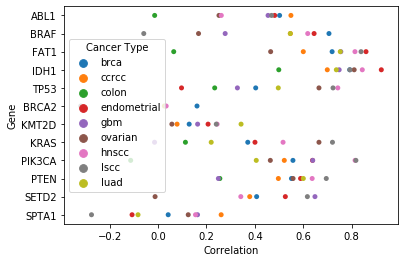

In [17]:
plt = sns.stripplot(x="Correlation",y="Gene",hue="Cancer Type",data=my_df,jitter=0)
# plt.legend_.remove()
plt

In [12]:
normal_df = make_df_with_genes(gene_list,cancer_list,type_dict,tissue_type = "normal")

cptac warning: Due to dropping the specified levels, dataframe now has 655 duplicated column headers. (/Users/benkk/Documents/GitHub/pancancerProteinMRNA/notebook_steps/get_correlations.py, line 16)
cptac warning: Due to dropping the specified levels, dataframe now has 907 duplicated column headers. (/Users/benkk/Documents/GitHub/pancancerProteinMRNA/notebook_steps/get_correlations.py, line 16)
cptac warning: Due to dropping the specified levels, dataframe now has 2495 duplicated column headers. (/Users/benkk/Documents/GitHub/pancancerProteinMRNA/notebook_steps/get_correlations.py, line 20)
cptac warning: Due to dropping the specified levels, dataframe now has 745 duplicated column headers. (/Users/benkk/Documents/GitHub/pancancerProteinMRNA/notebook_steps/get_correlations.py, line 16)
cptac warning: Due to dropping the specified levels, dataframe now has 1162 duplicated column headers. (/Users/benkk/Documents/GitHub/pancancerProteinMRNA/notebook_steps/get_correlations.py, line 16)
cpt

cptac warning: Due to dropping the specified levels, dataframe now has 2495 duplicated column headers. (/Users/benkk/Documents/GitHub/pancancerProteinMRNA/notebook_steps/get_correlations.py, line 20)
cptac warning: Due to dropping the specified levels, dataframe now has 745 duplicated column headers. (/Users/benkk/Documents/GitHub/pancancerProteinMRNA/notebook_steps/get_correlations.py, line 16)
cptac warning: Due to dropping the specified levels, dataframe now has 1162 duplicated column headers. (/Users/benkk/Documents/GitHub/pancancerProteinMRNA/notebook_steps/get_correlations.py, line 16)
cptac warning: Due to dropping the specified levels, dataframe now has 858 duplicated column headers. (/Users/benkk/Documents/GitHub/pancancerProteinMRNA/notebook_steps/get_correlations.py, line 16)
cptac warning: Due to dropping the specified levels, dataframe now has 655 duplicated column headers. (/Users/benkk/Documents/GitHub/pancancerProteinMRNA/notebook_steps/get_correlations.py, line 16)
cpt

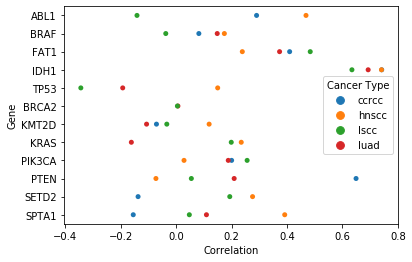

In [18]:
plt = sns.stripplot(x="Correlation",y="Gene",hue="Cancer Type",data=normal_df,jitter=0)
# plt.legend_.remove()
plt

In [14]:
#Make sure colors are the same, make axes equal as well.
#Use parameter quiet when using the CPTAC package
#Add introductory readings to intro in outline
#Be somewhat familiar with genes and where they are talked about